In [1]:
import os
from pathlib import Path

# ---------- 1) Stop any existing SparkSession (if any) ----------
try:
    spark.stop()
    print("Stopped existing SparkSession.")
except Exception:
    print("No SparkSession to stop (ok).")

# ---------- 2) Clear PySpark global state (fixes dead Py4J gateway) ----------
try:
    from pyspark.context import SparkContext
    from pyspark.sql import SparkSession

    for k in ["PYSPARK_GATEWAY_PORT", "PYSPARK_GATEWAY_SECRET"]:
        if k in os.environ:
            os.environ.pop(k, None)
            print(f"Cleared env {k}")

    SparkContext._active_spark_context = None
    SparkContext._gateway = None
    SparkContext._jvm = None

    try:
        SparkSession._instantiatedContext = None
        SparkSession._activeSession = None
        SparkSession._defaultSession = None
    except Exception:
        pass

    print("✅ PySpark internals reset")
except Exception as e:
    print("⚠️ Reset step warning:", type(e).__name__, e)

# ---------- 3) Start Spark (stable local mode) ----------
from pyspark.sql import SparkSession

OUTPUT_ROOT = Path.home() / "opendota_processed"
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

SPARK_LOCAL_DIR = OUTPUT_ROOT / "spark_local"
SPARK_LOCAL_DIR.mkdir(parents=True, exist_ok=True)

spark = (
    SparkSession.builder
    .appName("OpenDota_Notebook")
    .master("local[*]")  # stable; we can change later
    .config("spark.local.dir", str(SPARK_LOCAL_DIR))
    .config("spark.sql.shuffle.partitions", "400")
    .config("spark.sql.adaptive.enabled", "true")
    # IMPORTANT: avoid surprise broadcasts that can destabilize the JVM
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")

print("✅ Spark started:", spark.version)
print(" - Master:", spark.sparkContext.master)
print(" - Spark UI:", spark.sparkContext.uiWebUrl)
print("alive_check =", spark.range(1).count())

No SparkSession to stop (ok).
✅ PySpark internals reset
✅ Spark started: 4.1.1
 - Master: local[*]
 - Spark UI: http://LAPTOP-GGN1Q8MB.mshome.net:4040
alive_check = 1


In [2]:
import os
from pathlib import Path

# 1) Stop if possible
try:
    spark.stop()
    print("Stopped SparkSession.")
except Exception:
    print("No SparkSession to stop (ok).")

# 2) Hard reset PySpark globals (dead gateway fix)
from pyspark.context import SparkContext
from pyspark.sql import SparkSession

for k in ["PYSPARK_GATEWAY_PORT", "PYSPARK_GATEWAY_SECRET"]:
    os.environ.pop(k, None)

SparkContext._active_spark_context = None
SparkContext._gateway = None
SparkContext._jvm = None
SparkSession._instantiatedContext = None
SparkSession._activeSession = None
SparkSession._defaultSession = None

# 3) Start Spark (stable settings)
OUTPUT_ROOT = Path.home() / "opendota_processed"
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
SPARK_LOCAL_DIR = OUTPUT_ROOT / "spark_local"
SPARK_LOCAL_DIR.mkdir(parents=True, exist_ok=True)

spark = (
    SparkSession.builder
    .appName("OpenDota_Preprocessing_Notebook_Stable")
    .master("local[4]")                 # <-- reduce threads for stability
    .config("spark.ui.enabled", "true")# <-- remove UI port issues while debugging
    .config("spark.local.dir", str(SPARK_LOCAL_DIR))
    .config("spark.sql.shuffle.partitions", "32")
    .config("spark.sql.adaptive.enabled", "false")  # <-- disable AQE for now
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")
print("✅ Spark started:", spark.version)
print(" - Master:", spark.sparkContext.master)
print(" - Spark UI:", spark.sparkContext.uiWebUrl)
print("alive_check =", spark.range(1).count())

Stopped SparkSession.
✅ Spark started: 4.1.1
 - Master: local[4]
 - Spark UI: http://LAPTOP-GGN1Q8MB.mshome.net:4040
alive_check = 1


In [3]:
input_path = r"C:\projects\bigdata\data\opendota\*.csv" #ibahin path 

In [4]:
from pyspark.sql.types import StructType, StructField, LongType, IntegerType, StringType

schema = StructType([
    StructField("match_id", LongType(), True),
    StructField("match_seq_num", LongType(), True), # Needed to maintain index position
    StructField("radiant_win", StringType(), True),
    StructField("start_time", LongType(), True),
    StructField("duration", IntegerType(), True)
])

df_raw = spark.read.format("csv") \
    .option("header", "true") \
    .schema(schema) \
    .load(input_path)

df_matches = df_raw.select("match_id", "radiant_win", "start_time", "duration")

In [5]:
df_matches.select("match_id","radiant_win", "start_time", "duration").show(5)

+---------+-----------+----------+--------+
| match_id|radiant_win|start_time|duration|
+---------+-----------+----------+--------+
|473260719|          t|1390019262|    3234|
|473260722|          f|1390019274|    2360|
|473260723|          f|1390019260|    2546|
|473260724|          f|1390019278|    2647|
|473260725|          t|1390019250|    3030|
+---------+-----------+----------+--------+
only showing top 5 rows


In [6]:
from pyspark.sql import functions as F

# count of matches before drop
before_count = df_matches.count()

# constructing clean match data
matches_clean = df_matches.withColumn("match_id", F.col("match_id").cast("long")) \
                          .withColumn("start_time", F.col("start_time").cast("long")) \
                          .withColumn("duration", F.col("duration").cast("int")) \
                          .withColumn("radiant_win", F.col("radiant_win") == "t") \
                          .dropna(subset=["match_id"]) \
                          .dropDuplicates(["match_id"])

# Justification: Matches < 5 mins (300s) are usually 'null' games (early abandons).
# Matches > 3 hours (10800s) are extreme outliers/server errors in Dota 2.
lower_bound = 300
upper_bound = 10800
matches_clean = matches_clean.filter((F.col("duration") >= lower_bound) & (F.col("duration") <= upper_bound))

# D) Capture After Count
after_count = matches_clean.count()

In [7]:
# null rate calc
null_rate_df = matches_clean.select([
    (F.count(F.when(F.col(c).isNull(), c)) / after_count * 100).alias(c) 
    for c in matches_clean.columns
])

print("--- TASK 4: EVIDENCE ---")
print(f"Before cleaning: {before_count} rows")
print(f"After cleaning:  {after_count} rows")
print(f"Rows removed:    {before_count - after_count}")

print("\n--- Null Rate Summary (%) ---")
null_rate_df.show()

--- TASK 4: EVIDENCE ---
Before cleaning: 500000 rows
After cleaning:  497320 rows
Rows removed:    2680

--- Null Rate Summary (%) ---
+--------+--------------------+----------+--------+
|match_id|         radiant_win|start_time|duration|
+--------+--------------------+----------+--------+
|     0.0|2.010777768840987...|       0.0|     0.0|
+--------+--------------------+----------+--------+



In [8]:
matches_clean.printSchema()
matches_clean.limit(5).show()

root
 |-- match_id: long (nullable = true)
 |-- radiant_win: boolean (nullable = true)
 |-- start_time: long (nullable = true)
 |-- duration: integer (nullable = true)

+----------+-----------+----------+--------+
|  match_id|radiant_win|start_time|duration|
+----------+-----------+----------+--------+
| 473260800|      false|1390019708|    1843|
|1009842190|      false|1415362477|    2950|
|1808667856|      false|1442797852|    3096|
| 692810562|      false|1401589879|    2141|
|1980325600|       true|1449295127|    2140|
+----------+-----------+----------+--------+



In [9]:
from pyspark.sql import functions as F

# derive day, year, month, and duration_min
matches_features = matches_clean.withColumn("start_ts", F.from_unixtime("start_time").cast("timestamp")) \
    .withColumn("year", F.year("start_ts")) \
    .withColumn("month", F.month("start_ts")) \
    .withColumn("day", F.day("start_ts")) \
    .withColumn("duration_min", F.col("duration") / 60)

# bins: <20, 20–30, 30-40, 40-50, 50-60, 60+
matches_features = matches_features.withColumn("duration_bin", 
    F.when(F.col("duration_min") < 20, "<20")
     .when((F.col("duration_min") >= 20) & (F.col("duration_min") < 30), "20-30")
     .when((F.col("duration_min") >= 30) & (F.col("duration_min") < 40), "30-40")
     .when((F.col("duration_min") >= 40) & (F.col("duration_min") < 50), "40-50")
     .when((F.col("duration_min") >= 50) & (F.col("duration_min") < 60), "50-60")
     .otherwise("60+")
)

# preview of newest features 
matches_features.select("match_id", "start_ts", "year", "month", "day", "duration_min", "duration_bin").show(5)

+----------+-------------------+----+-----+---+------------------+------------+
|  match_id|           start_ts|year|month|day|      duration_min|duration_bin|
+----------+-------------------+----+-----+---+------------------+------------+
| 473260800|2014-01-18 12:35:08|2014|    1| 18|30.716666666666665|       30-40|
|1009842190|2014-11-07 20:14:37|2014|   11|  7|49.166666666666664|       40-50|
|1808667856|2015-09-21 09:10:52|2015|    9| 21|              51.6|       50-60|
| 692810562|2014-06-01 10:31:19|2014|    6|  1| 35.68333333333333|       30-40|
|1980325600|2015-12-05 13:58:47|2015|   12|  5|35.666666666666664|       30-40|
+----------+-------------------+----+-----+---+------------------+------------+
only showing top 5 rows


In [10]:
# define the output path
parquet_path = f"data/matches_features.parquet"

# write the data partitioned by year and month
matches_features.write.mode("overwrite") \
    .partitionBy("year", "month") \
    .parquet(parquet_path)

print(f"✅ Data successfully written to: {parquet_path}")

✅ Data successfully written to: data/matches_features.parquet


In [11]:
import os
os.system(f"ls -R {parquet_path} | head -n 20")

255

In [38]:
df_p = spark.read.parquet(parquet_path)
filtered_query = df_p.filter((F.col("year") == 2014) & (F.col("month") == 1))
filtered_query.explain(True)


== Parsed Logical Plan ==
'Filter 'and('`=`('year, 2014), '`=`('month, 1))
+- Relation [match_id#421L,radiant_win#422,start_time#423L,duration#424,start_ts#425,day#426,duration_min#427,duration_bin#428,year#429,month#430] parquet

== Analyzed Logical Plan ==
match_id: bigint, radiant_win: boolean, start_time: bigint, duration: int, start_ts: timestamp, day: int, duration_min: double, duration_bin: string, year: int, month: int
Filter ((year#429 = 2014) AND (month#430 = 1))
+- Relation [match_id#421L,radiant_win#422,start_time#423L,duration#424,start_ts#425,day#426,duration_min#427,duration_bin#428,year#429,month#430] parquet

== Optimized Logical Plan ==
Filter ((isnotnull(year#429) AND isnotnull(month#430)) AND ((year#429 = 2014) AND (month#430 = 1)))
+- Relation [match_id#421L,radiant_win#422,start_time#423L,duration#424,start_ts#425,day#426,duration_min#427,duration_bin#428,year#429,month#430] parquet

== Physical Plan ==
*(1) ColumnarToRow
+- FileScan parquet [match_id#421L,radiant

EDA

In [13]:
# aggregate by year and month
# calculate both count (activity) and mean (trend)
activity_trend = df_p.groupBy("year", "month") \
    .agg(
        F.count("match_id").alias("match_count"),
        F.avg("duration_min").alias("avg_duration")
    ) \
    .orderBy("year", "month") \
    .toPandas() # small result set, safe for Pandas

print("--- Match Activity & Duration Trends (First 5 Rows) ---")
print(activity_trend.head())

--- Match Activity & Duration Trends (First 5 Rows) ---
   year  month  match_count  avg_duration
0  2011      7            7     48.802381
1  2011      9            2     18.216667
2  2011     10           19     41.304386
3  2011     11           34     37.098529
4  2011     12           96     40.998438


In [14]:
activity_trend['year'].combine(activity_trend['month'], lambda year, month: f'{year}-{month:02d}')

0     2011-07
1     2011-09
2     2011-10
3     2011-11
4     2011-12
5     2012-01
6     2012-02
7     2012-03
8     2012-04
9     2012-05
10    2012-06
11    2012-07
12    2012-08
13    2012-09
14    2012-10
15    2012-11
16    2012-12
17    2013-01
18    2013-02
19    2013-03
20    2013-04
21    2013-05
22    2013-06
23    2013-07
24    2013-08
25    2013-09
26    2013-10
27    2013-11
28    2013-12
29    2014-01
30    2014-02
31    2014-03
32    2014-04
33    2014-05
34    2014-06
35    2014-07
36    2014-08
37    2014-09
38    2014-10
39    2014-11
40    2014-12
41    2015-01
42    2015-02
43    2015-03
44    2015-04
45    2015-05
46    2015-06
47    2015-07
48    2015-08
49    2015-09
50    2015-10
51    2015-11
52    2015-12
53    2016-01
54    2016-02
55    2016-03
56    2016-04
dtype: str

In [15]:
# Count matches per bin
duration_dist = df_p.groupBy("duration_bin") \
    .count() \
    .orderBy("duration_bin") \
    .toPandas()

print("\n--- Duration Distribution ---")
print(duration_dist)


--- Duration Distribution ---
  duration_bin   count
0        20-30   56290
1        30-40  162962
2        40-50  157166
3        50-60   78304
4          60+   29296
5          <20   13302


In [16]:
# Calculate win rate percentage by year
win_rate_stability = df_p.withColumn("win_int", F.col("radiant_win").cast("int")) \
    .groupBy("year") \
    .agg(F.avg("win_int").alias("radiant_win_rate")) \
    .orderBy("year") \
    .toPandas()

print("\n--- Radiant Win Rate Stability ---")
print(win_rate_stability)


--- Radiant Win Rate Stability ---
   year  radiant_win_rate
0  2011          0.563291
1  2012          0.509705
2  2013          0.515877
3  2014          0.519029
4  2015          0.515306
5  2016          0.513675


In [17]:
# Convert start_ts to a simple date format and count
daily_activity = df_p.withColumn("date", F.to_date("start_ts")) \
    .groupBy("date") \
    .count() \
    .withColumnRenamed("count", "total_games") \
    .orderBy("date") \
    .toPandas()

print("--- Daily Match Activity ---")
print(daily_activity.head(10))

--- Daily Match Activity ---
         date  total_games
0  2011-07-02            1
1  2011-07-03            1
2  2011-07-04            1
3  2011-07-07            1
4  2011-07-09            1
5  2011-07-17            1
6  2011-07-24            1
7  2011-09-26            1
8  2011-09-30            1
9  2011-10-01            2


In [18]:
play_time_dist = df_p.groupBy("duration_bin") \
    .count() \
    .withColumnRenamed("count", "frequency") \
    .orderBy("duration_bin") \
    .toPandas()

print("\n--- Play Time Distribution ---")
print(play_time_dist)


--- Play Time Distribution ---
  duration_bin  frequency
0        20-30      56290
1        30-40     162962
2        40-50     157166
3        50-60      78304
4          60+      29296
5          <20      13302


In [19]:
# Calculate mean of radiant_win (True=1, False=0)
win_rate_trend = df_p.withColumn("win_val", F.col("radiant_win").cast("int")) \
    .groupBy("year", "month") \
    .agg(F.avg("win_val").alias("radiant_win_rate")) \
    .orderBy("year", "month") \
    .toPandas()

print("\n--- Win Rate Trend (Monthly) ---")
print(win_rate_trend.head(10))


--- Win Rate Trend (Monthly) ---
   year  month  radiant_win_rate
0  2011      7          0.142857
1  2011      9          1.000000
2  2011     10          0.684211
3  2011     11          0.441176
4  2011     12          0.604167
5  2012      1          0.476190
6  2012      2          0.514360
7  2012      3          0.518519
8  2012      4          0.559160
9  2012      5          0.534247


end of EDA

In [20]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install --upgrade nbformat plotly




[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# aggregate by year and month
# calculate both count (activity) and mean (trend)
activity_trend = df_p.groupBy("year", "month") \
    .agg(
        F.count("match_id").alias("match_count"),
        F.avg("duration_min").alias("avg_duration")
    ) \
    .orderBy("year", "month") \
    .toPandas() # small result set, safe for Pandas

print("--- Match Activity & Duration Trends (First 5 Rows) ---")
print(activity_trend.head())

--- Match Activity & Duration Trends (First 5 Rows) ---
   year  month  match_count  avg_duration
0  2011      7            7     48.802381
1  2011      9            2     18.216667
2  2011     10           19     41.304386
3  2011     11           34     37.098529
4  2011     12           96     40.998438


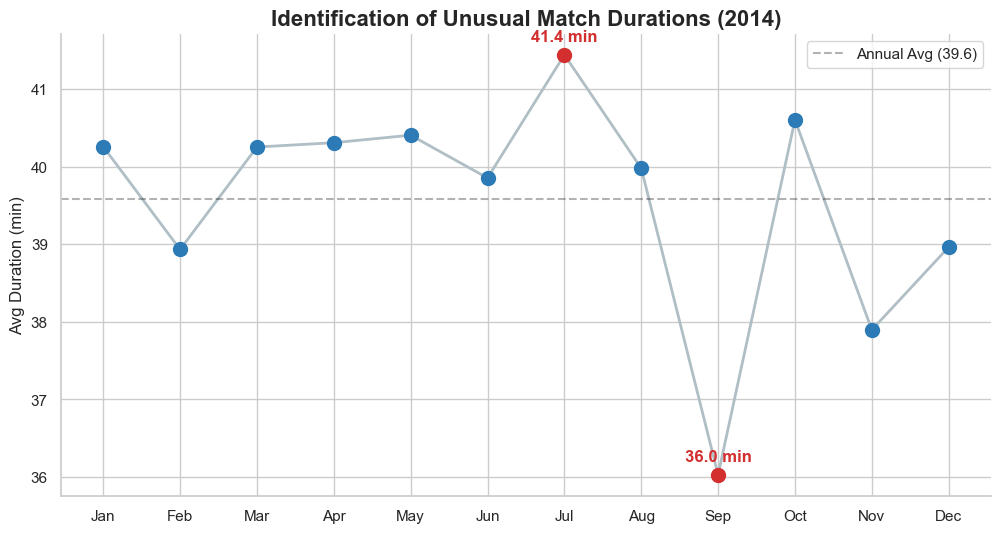

In [23]:
# ---- Plot 1: Line: average duration trend ---
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Clean and Sort
df_clean = activity_trend.groupby('month')['avg_duration'].mean().reset_index().sort_values('month')
avg_val = df_clean["avg_duration"].mean()
std_val = df_clean["avg_duration"].std()

# 2. Setup Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot the main line
plt.plot(df_clean["month"], df_clean["avg_duration"], color='#b0bec5', linewidth=2, zorder=1)

# 3. Highlight Unusual Months (Outliers > 1.5 Standard Deviations)
for i, row in df_clean.iterrows():
    # Logic for "unusual": significantly above or below average
    is_unusual = abs(row['avg_duration'] - avg_val) > (1.2 * std_val)
    
    color = '#d32f2f' if is_unusual else '#2c7bb6'
    plt.scatter(row['month'], row['avg_duration'], color=color, s=100, zorder=2)
    
    # Add text labels for the unusual months
    if is_unusual:
        plt.annotate(f"{row['avg_duration']:.1f} min", 
                     (row['month'], row['avg_duration']),
                     textcoords="offset points", xytext=(0,10), ha='center', 
                     fontweight='bold', color=color)

# 4. Final Formatting
plt.axhline(avg_val, color='black', linestyle='--', alpha=0.3, label=f'Annual Avg ({avg_val:.1f})')
plt.title("Identification of Unusual Match Durations (2014)", fontsize=16, fontweight='bold')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel("Avg Duration (min)")

sns.despine()
plt.legend()
plt.show()

In [24]:
activity_trend = activity_trend.sort_values("month")

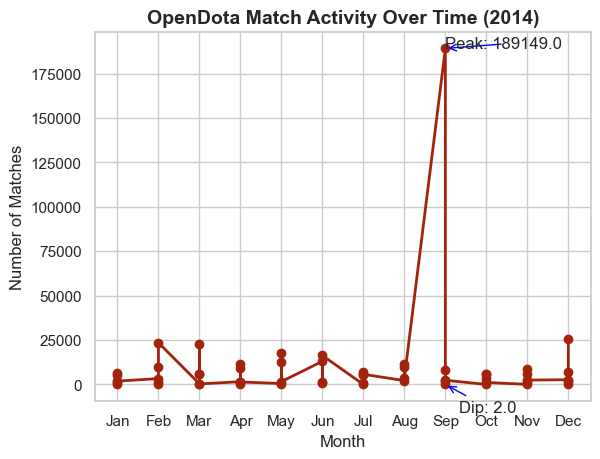

In [25]:
plt.figure()

plt.plot(activity_trend["month"], activity_trend["match_count"], 
         marker='o', color='#A4230D', linewidth=2, markersize=6, label='Match Volume') #dota colors

max_month = activity_trend.loc[activity_trend['match_count'].idxmax()]
min_month = activity_trend.loc[activity_trend['match_count'].idxmin()]

plt.annotate(f'Peak: {max_month["match_count"]}', 
             xy=(max_month["month"], max_month["match_count"]), arrowprops=dict(arrowstyle='->', color='blue'))

plt.annotate(f'Dip: {min_month["match_count"]}', 
             xy=(min_month["month"], min_month["match_count"]), xytext=(10, -20),textcoords='offset points', arrowprops=dict(arrowstyle='->', color='blue'))

plt.title("OpenDota Match Activity Over Time (2014)", fontsize=14, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Number of Matches")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(1, 13), labels=month_names)
plt.show()

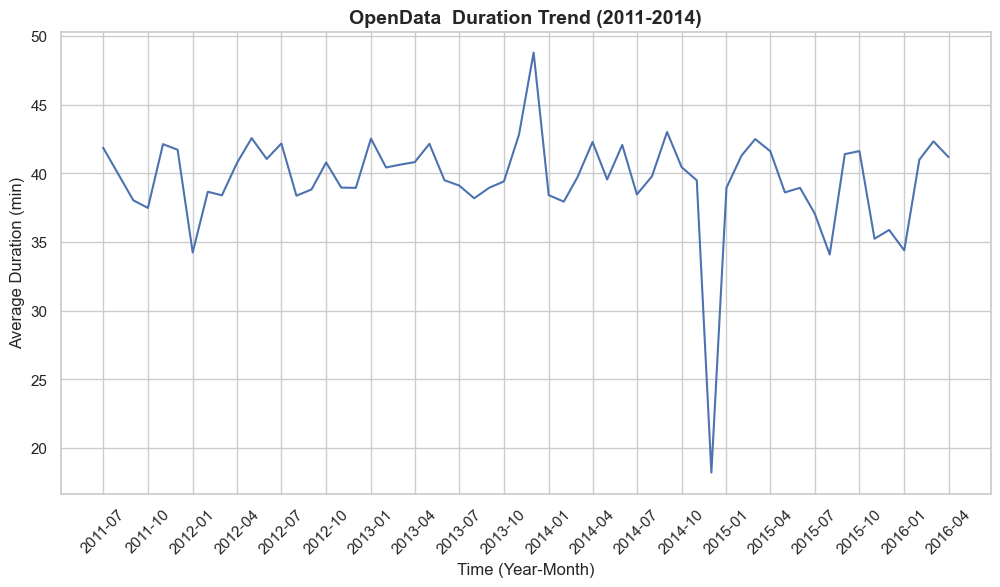

In [26]:
from matplotlib.dates import DateFormatter, MonthLocator
plt.figure(figsize=(12, 6))
x = pd.to_datetime(activity_trend['year'].combine(activity_trend['month'], lambda year, month: f'{year}-{month:02d}')).sort_values()
plt.plot(x,
         activity_trend['avg_duration'])
plt.title("OpenData  Duration Trend (2011-2014)", fontsize=14, fontweight='bold')
plt.xlabel("Time (Year-Month)")
plt.ylabel('Average Duration (min)')
plt.gca().xaxis.set_major_locator(
    MonthLocator(bymonth = [1, 4, 7, 10])
)

plt.gca().xaxis.set_major_formatter(
    DateFormatter("%Y-%m")
)
plt.xticks(rotation = 45)
plt.show()

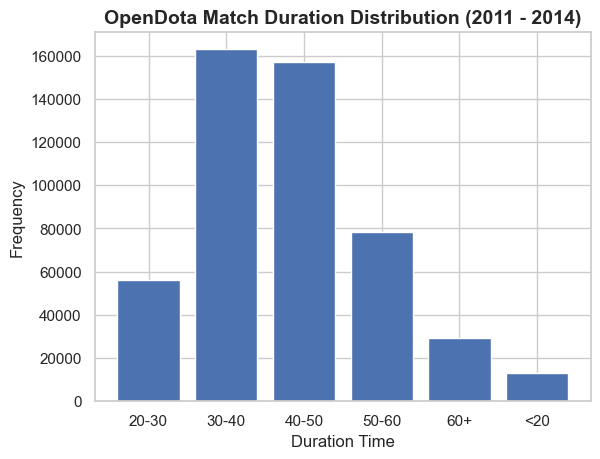

In [27]:
## 
plt.bar(play_time_dist['duration_bin'], play_time_dist["frequency"])
plt.title("OpenDota Match Duration Distribution (2011 - 2014)", fontsize=14, fontweight='bold')
plt.xlabel("Duration Time")
plt.ylabel("Frequency")
plt.show()

In [28]:
import pandas as pd

def try_plotly():
    import plotly.express as px
    import plotly.graph_objects as go

    # 1) Activity over time
    fig1 = px.line(x=pd.to_datetime(activity_trend['year'].combine(activity_trend['month'], lambda year, month: f'{year}-{month:02d}')).sort_values(),
                   y=activity_trend['match_count'],
                   title="Interactive: Match Activity Over Time")
    fig1.show()

    # 2) Avg duration trend
    fig2 = px.line(x=pd.to_datetime(activity_trend['year'].combine(activity_trend['month'], lambda year, month: f'{year}-{month:02d}')).sort_values(),
                   y=activity_trend['avg_duration'], title="Interactive: Average Duration Trend")
    fig2.show()

    # 3) Duration bin bar
    fig3 = px.bar(play_time_dist, x="duration_bin", y="frequency", title="Interactive: Duration Distribution (Binned)")
    fig3.show()

try:
    try_plotly()
    print("✅ Plotly interactive charts rendered.")
except Exception as e:
    print("⚠️ Plotly not available (or failed to render). Falling back to table previews.")
    print(type(e).__name__, ":", e)

    print("\n--- activity_trend head ---")
    display(activity_trend.head(10))

    print("\n--- activity_trend head ---")
    display(activity_trend.head(10))

    print("\n--- play_time_dist ---")
    display(play_time_dist.head(10))


✅ Plotly interactive charts rendered.


<span style="font-size: 50px;">MapReduce</span>

# 
Map Phase
#

In this phase, each input row wherein a record of the dataset is transformed into a key-value pair.

- Key: (year, month)
- Value: (1, duration, win)

For example, if a row has date = 2024-03-15, duration = 35, win = 1

The mapper will emit: ((2024, 3), (1, 35, 1))

The meaning of these values are 1 being the count of one record, the second value being the duration that is used for computing the total/average duration, and the third value being the win that is used for computing total wins.

#
Shuffle phase
#

This phase is a wide transformation in Spark. All key-value pairs are redistributed across nodes. Records with the same key (year, month) are grouped together.

An example after the shuffle would be:

(2024, 3) → [(1, 35, 1), (1, 40, 0), (1, 50, 1)]

(2024, 4) → [(1, 20, 0), (1, 25, 1)]

This step is expensive because this involves network transfer.

#
Reduce phase
#

After the shuffle phase, it aggregates the values of each key. For each (year, month), the input would be [(1, d1, w1), (1, d2, w2), ...]. After that it would compute for total count, total duration, total wins, average duration, and win rate.

Example of computation:
(2024, 3):
count = 3
total_duration = 35 + 40 + 50 = 125
total_wins = 1 + 0 + 1 = 2

avg_duration = 125 / 3
win_rate = 2 / 3

The output of the computation would be:
((2024, 3), (count, avg_duration, win_rate))



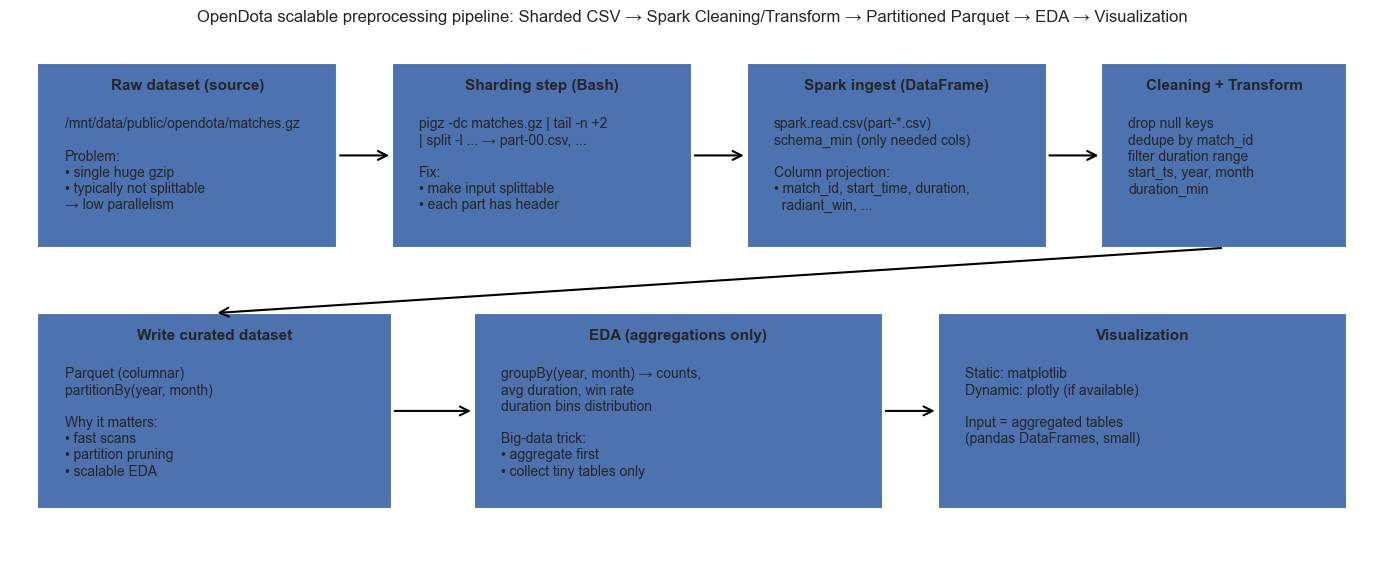

In [43]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

fig = plt.figure(figsize=(14, 6))
ax = plt.gca()
ax.axis("off")

def box(x, y, w, h, title, lines):
    ax.add_patch(Rectangle((x, y), w, h, fill=True, linewidth=1.5))
    ax.text(x + w/2, y + h - 0.03, title, ha="center", va="top",
            fontsize=11, fontweight="bold")
    ax.text(x + 0.02, y + h - 0.10, "\n".join(lines), ha="left", va="top",
            fontsize=10)

def arrow(x1, y1, x2, y2):
    ax.add_patch(FancyArrowPatch((x1, y1), (x2, y2),
                                 arrowstyle="->", mutation_scale=16, linewidth=1.5, color = 'black'))

# Row 1: Raw -> Shards -> Spark Ingest
box(0.02, 0.60, 0.22, 0.34, "Raw dataset (source)",
    [
        "/mnt/data/public/opendota/matches.gz",
        "",
        "Problem:",
        "• single huge gzip",
        "• typically not splittable",
        "→ low parallelism"
    ])

box(0.28, 0.60, 0.22, 0.34, "Sharding step (Bash)",
    [
        "pigz -dc matches.gz | tail -n +2",
        "| split -l ... → part-00.csv, ...",
        "",
        "Fix:",
        "• make input splittable",
        "• each part has header"
    ])

box(0.54, 0.60, 0.22, 0.34, "Spark ingest (DataFrame)",
    [
        "spark.read.csv(part-*.csv)",
        "schema_min (only needed cols)",
        "",
        "Column projection:",
        "• match_id, start_time, duration,",
        "  radiant_win, ..."
    ])

box(0.80, 0.60, 0.18, 0.34, "Cleaning + Transform",
    [
        "drop null keys",
        "dedupe by match_id",
        "filter duration range",
        "start_ts, year, month",
        "duration_min"
    ])

# Row 2: Parquet -> EDA -> Visualization
box(0.02, 0.12, 0.26, 0.36, "Write curated dataset",
    [
        "Parquet (columnar)",
        "partitionBy(year, month)",
        "",
        "Why it matters:",
        "• fast scans",
        "• partition pruning",
        "• scalable EDA"
    ])

box(0.34, 0.12, 0.30, 0.36, "EDA (aggregations only)",
    [
        "groupBy(year, month) → counts,",
        "avg duration, win rate",
        "duration bins distribution",
        "",
        "Big-data trick:",
        "• aggregate first",
        "• collect tiny tables only"
    ])

box(0.68, 0.12, 0.30, 0.36, "Visualization",
    [
        "Static: matplotlib",
        "Dynamic: plotly (if available)",
        "",
        "Input = aggregated tables",
        "(pandas DataFrames, small)"
    ])

# Arrows (top flow)
arrow(0.24, 0.77, 0.28, 0.77)  # raw -> sharding
arrow(0.50, 0.77, 0.54, 0.77)  # sharding -> ingest
arrow(0.76, 0.77, 0.80, 0.77)  # ingest -> clean/transform

# Down arrow to Parquet
arrow(0.89, 0.60, 0.15, 0.48)  # clean/transform -> write curated (diagonal)

# Bottom flow
arrow(0.28, 0.30, 0.34, 0.30)  # parquet -> EDA
arrow(0.64, 0.30, 0.68, 0.30)  # EDA -> viz

plt.title("OpenDota scalable preprocessing pipeline: Sharded CSV → Spark Cleaning/Transform → Partitioned Parquet → EDA → Visualization")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Ensure pandas tables exist from Cell 7
for name in ["activity_pd", "trend_pd", "bin_pd", "skill_pd"]:
    assert name in globals(), f"Missing {name}. Run the matplotlib cell first."

def try_plotly():
    import plotly.express as px

    # 1) Activity over time
    fig1 = px.line(activity_pd, x="ym", y="n_matches", title="Interactive: Match Activity Over Time")
    fig1.show()

    # 2) Avg duration trend
    fig2 = px.line(trend_pd, x="ym", y="avg_duration_min", title="Interactive: Average Duration Trend")
    fig2.show()

    # 3) Duration bin bar
    fig3 = px.bar(bin_pd, x="duration_bin", y="n_matches", title="Interactive: Duration Distribution (Binned)")
    fig3.show()

    # 4) Win rate by skill (skill can be null)
    tmp = skill_pd.copy()
    tmp["skill_label"] = tmp["skill"].astype("Int64").astype(str).replace("<NA>", "NULL")
    fig4 = px.line(tmp, x="skill_label", y="radiant_win_rate", markers=True, title="Interactive: Radiant Win Rate by Skill")
    fig4.show()

try:
    try_plotly()
    print("✅ Plotly interactive charts rendered.")
except Exception as e:
    print("⚠️ Plotly not available (or failed to render). Falling back to table previews.")
    print(type(e).__name__, ":", e)

    print("\n--- activity_pd head ---")
    display(activity_pd.head(10))

    print("\n--- trend_pd head ---")
    display(trend_pd.head(10))

    print("\n--- bin_pd ---")
    display(bin_pd)

    print("\n--- skill_pd head ---")
    display(skill_pd.head(10))


AssertionError: Missing activity_pd. Run the matplotlib cell first.